<a href="https://colab.research.google.com/github/ArnyWu/-Preview-AI-/blob/main/week6%E4%BD%9C%E6%A5%AD_%E6%99%82%E9%96%93%E5%BA%8F%E5%88%97%E3%80%81%E9%87%8F%E5%8C%96%E4%BA%A4%E6%98%93%E7%AD%96%E7%95%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 取得股價資料

In [1]:
import yfinance as yf
import pandas as pd
import datetime as dt
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

In [7]:
# 輸入股票代號
stock_id = "3231.tw" #緯創

'''今天往前算幾天'''
# 資料結束時間
end = dt.date.today()
# 抓取半年資料（現在-過去180天）
start = end - dt.timedelta(days=180)

# 參數1: 股票代號, 參數2: 開始時間, 參數3: 結束時間
data = yf.download(stock_id, start=start, end=end).reset_index()

df_stat = data.copy()
df_stat

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2024-04-22,113.0,114.0,108.5,108.5,105.936386,77007712
1,2024-04-23,111.0,112.5,109.5,111.0,108.377319,36485658
2,2024-04-24,113.5,117.5,113.0,115.5,112.770996,86543907
3,2024-04-25,114.5,114.5,112.0,112.0,109.353691,38537942
4,2024-04-26,114.5,115.5,112.5,113.0,110.330063,38356287
...,...,...,...,...,...,...,...
115,2024-10-09,103.5,105.5,103.0,105.0,105.000000,39992237
116,2024-10-11,105.5,109.0,104.5,108.5,108.500000,55431430
117,2024-10-14,109.5,110.0,107.5,109.0,109.000000,31188138
118,2024-10-15,110.0,111.0,108.0,109.0,109.000000,43741059


# <b>1. ARIMA（整合移動平均自回歸模型）</b>

In [8]:
# 將日期欄位轉為datetime格式
df_stat['Date'] = pd.to_datetime(df_stat['Date'])
# 將日期欄位設為索引
df_stat.set_index('Date', inplace=True)

df_stat

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-22,113.0,114.0,108.5,108.5,105.936386,77007712
2024-04-23,111.0,112.5,109.5,111.0,108.377319,36485658
2024-04-24,113.5,117.5,113.0,115.5,112.770996,86543907
2024-04-25,114.5,114.5,112.0,112.0,109.353691,38537942
2024-04-26,114.5,115.5,112.5,113.0,110.330063,38356287
...,...,...,...,...,...,...
2024-10-09,103.5,105.5,103.0,105.0,105.000000,39992237
2024-10-11,105.5,109.0,104.5,108.5,108.500000,55431430
2024-10-14,109.5,110.0,107.5,109.0,109.000000,31188138


## 1.1 資料前處理

In [9]:
# 選擇收盤價作為預測目標
close_prices = df_stat['Close']

# 拆分資料分為訓練集(70%) 和測試集(30%)
train_size = int(len(close_prices) * 0.7)
train, test = close_prices[:train_size], close_prices[train_size:]

print(f"訓練集長度: {len(train)}")
print(f"測試集長度: {len(test)}")

訓練集長度: 84
測試集長度: 36


股市走勢視覺化

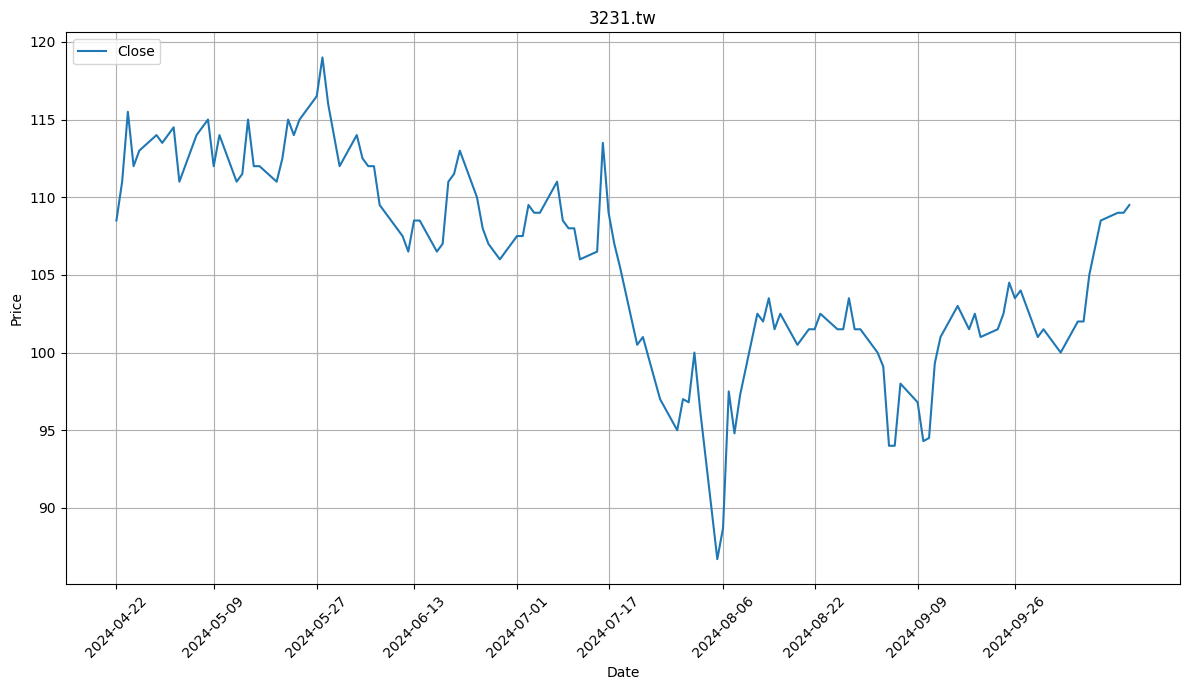

In [10]:
import matplotlib.pyplot as plt

# 畫布尺寸大小設定
plt.figure(figsize=(12, 7))

# 設定要繪製的資料欄位
plt.plot(df['Close'], label='Close')

# 設定 x 軸的時間標籤數量
num = 10  # 想在 x 軸上顯示的標籤數量
date = df.index.strftime('%Y-%m-%d')  # 格式化日期為 'YYYY-MM-DD'，此處使用索引作為日期

# 設定 x 軸的刻度和標籤
plt.xticks(df.index[::len(df)//num],  # 設定在 x 軸上顯示標籤的位置（索引），這些位置間隔為 len(df)//num
           date[::len(df)//num],      # 顯示在 x 軸上的日期標籤，數量為 num，間隔為 len(df)//num
           rotation = 45)             # 讓日期標籤旋轉 45 度，以避免標籤之間重疊

# 設定圖表的標題，x 軸和 y 軸的標籤
plt.title(f'{stock_id}')   # 將股票代號設為圖標
plt.xlabel('Date')         # x 軸標籤
plt.ylabel('Price')        # y 軸標籤
plt.legend(loc='upper left') # 在左上角顯示圖例
plt.grid(True)             # 在圖上顯示網格
plt.tight_layout()         # 自動調整圖表中的間距，避免元素之間的重疊

# 顯示圖表
plt.show()

## 1.2 ARIMA 模型

### **1.2.1 ADF檢定-檢查平穩性**

> 如果p-value < 0.05，則數據是平穩的；
否則，需要進行差分處理。




In [14]:
from statsmodels.tsa.stattools import adfuller

time_series = df_stat['Close']

# 執行 ADF 檢定
adf_result = adfuller(time_series)

# 解析檢定結果
print('ADF 檢定統計量:', adf_result[0])
print('p 值:', adf_result[1])
print('使用的滯後數:', adf_result[2])
print('臨界值:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

# 判斷是否平穩
if adf_result[1] < 0.05:
    print("時間序列是平穩的，因為 p 值小於 0.05")
else:
    print("時間序列不是平穩的，因為 p 值大於 0.05")

ADF 檢定統計量: -2.090135726069745
p 值: 0.24849953062034258
使用的滯後數: 0
臨界值:
   1%: -3.4865346059036564
   5%: -2.8861509858476264
   10%: -2.579896092790057
時間序列不是平穩的，因為 p 值大於 0.05


### **1.2.2 差分處理**

> 數據非平穩，進行一階差分



In [12]:
# 進行一次差分
df_stat['Close_diff'] = df_stat['Close'].diff()

# 檢查差分後的結果
df_stat[['Close', 'Close_diff']].head()

,Close,Close_diff
Date,,
2024-04-22,108.5,NaN
2024-04-23,111.0,2.5
2024-04-24,115.5,4.5
2024-04-25,112.0,-3.5
2024-04-26,113.0,1.0


再用ADF檢定一次

In [13]:
# 進行 ADF 檢定，檢查差分後的序列是否平穩
adf_result_diff = adfuller(df_stat['Close_diff'].dropna())  # 需要去除 NaN 值

# 解析檢定結果
print('ADF 檢定統計量:', adf_result_diff[0])
print('p 值:', adf_result_diff[1])
print('使用的滯後數:', adf_result_diff[2])
print('臨界值:')
for key, value in adf_result_diff[4].items():
    print(f'   {key}: {value}')

# 判斷是否平穩
if adf_result_diff[1] < 0.05:
    print("差分後的時間序列是平穩的，因為 p 值小於 0.05")
else:
    print("差分後的時間序列仍然不是平穩的，可能需要進行更多的差分")

ADF 檢定統計量: -9.502560414448924
p 值: 3.41413566182771e-16
使用的滯後數: 1
臨界值:
   1%: -3.487517288664615
   5%: -2.8865777180380032
   10%: -2.5801239192052012
差分後的時間序列是平穩的，因為 p 值小於 0.05


### 1.2.3 ARIMA模型建立


> * p (自我迴歸，AR)： 這個部分表示當前的數據可以用過去的數據來預測。舉例來說，如果你用今天的股價預測明天的股價，那就是自我迴歸。如果 p = 1，表示今天的值只跟昨天有關；如果 p = 2，表示今天的值不只跟昨天有關，還會跟前天的值有關。

> * d (差分，I)： 這個部分是用來處理趨勢的。如果數據隨著時間有上升或下降的趨勢，你需要通過「差分」來去掉這個趨勢。差分的意思是把今天的數值減去昨天的，這樣就可以看到數據的變化，而不是它的絕對值。如果 d = 1，表示進行一次差分來消除趨勢；如果 d = 2，表示進行兩次差分。

> * q (移動平均，MA)： 這個部分表示當前的數據會受到過去「誤差」的影響。誤差指的是預測與實際值之間的差距。如果 q = 1，表示今天的值會受到昨天預測錯誤的影響；如果 q = 2，表示今天的值還會受到前天預測錯誤的影響。

In [15]:
from statsmodels.tsa.arima.model import ARIMA  # 引入 ARIMA 模型
from math import sqrt  # 引入數學根號
import warnings  # 用來忽略警告訊息（可選）
warnings.filterwarnings("ignore")  # 忽略警告訊息

# 優化 ARIMA 模型參數的函數
def optimize_arima(train, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    best_model = None
    # 使用迴圈迭代 p, d, q 組合找出最佳參數
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    # order=(p, d, q)：非季節性ARIMA部分的參數，p 代表自回歸項，d 代表差分階數，q 代表移動平均項。
                    model = ARIMA(train, order=(p, d, q))

                    # 模型擬合
                    model_fit = model.fit()
                    yhat = model_fit.forecast(steps=len(test))

                    # 計算誤差RMSE
                    error = sqrt(mean_squared_error(test, yhat))

                    # 比較當前誤差與最好模型的誤差，存取最好的模型
                    if error < best_score:
                        # 存取最低的誤差分數, 存取最好的 p, d, q 參數
                        best_score, best_cfg = error, (p, d, q)
                        # 存取最好的模型
                        best_model = model_fit
                except:
                    continue

    return best_cfg, best_model

# 定義 p, d, q 參數範圍
p_values = range(0, 6)
d_values = range(0, 3)
q_values = range(0, 6)

# 找出 ARIMA 模型最佳參數
best_cfg, best_model = optimize_arima(train, p_values, d_values, q_values)

# 印出最佳参数
print(f'最佳參數 {best_cfg}')

最佳參數 (0, 1, 0)


In [16]:
# 預測
yhat = best_model.forecast(steps=len(test))

# 計算誤差RMSE
rmse_optimized = sqrt(mean_squared_error(test, yhat))

# 印出誤差RMSE
print(f"RMSE: {rmse_optimized}")

RMSE: 3.8379679275506904


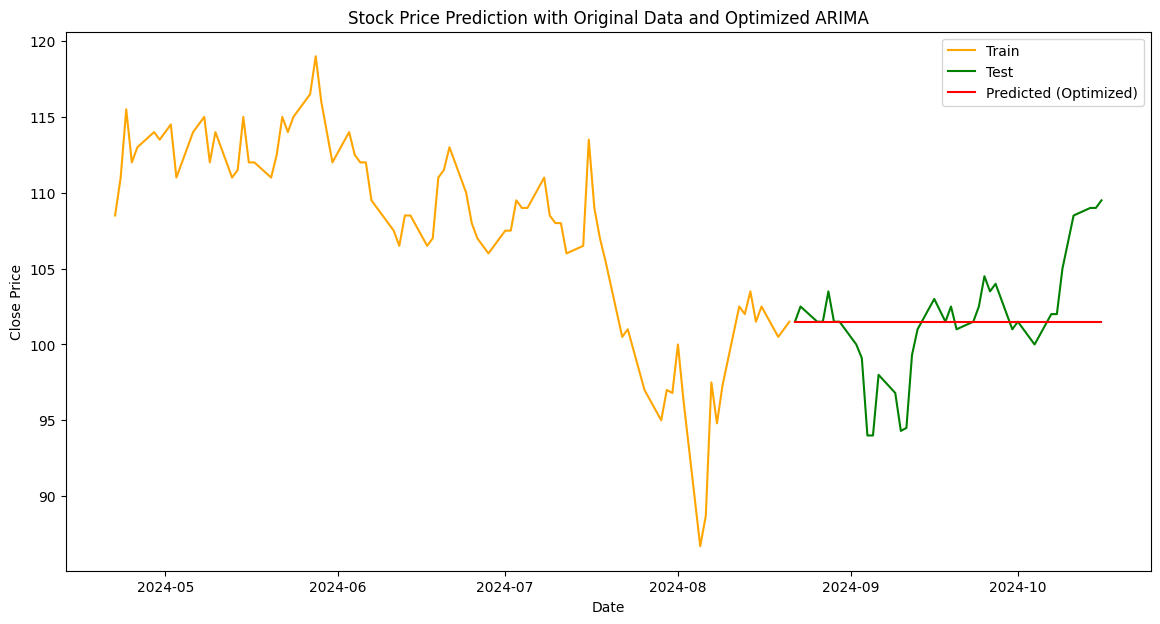

In [17]:
# 將訓練集、測試集、預測結果一同繪製
plt.figure(figsize=(14, 7))

# 繪製訓練集部分
plt.plot(train.index, train, label='Train', color='orange')

# 繪製測試集部分
plt.plot(test.index, test, label='Test', color='green')

# 繪製預測值
plt.plot(test.index, yhat, color='red', label='Predicted (Optimized)')

# 標題和圖例
plt.title('Stock Price Prediction with Original Data and Optimized ARIMA')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

# 顯示圖形
plt.show()

### AR1、AR2、AR3模型的比較

* AR1：僅使用前一個時刻的數據。
* AR2：使用前兩個時刻的數據。
* AR3：使用前三個時刻的數據。



AR1 RMSE: 5.5308834106730025
AR2 RMSE: 5.3756029298654315
AR3 RMSE: 4.793570695494776


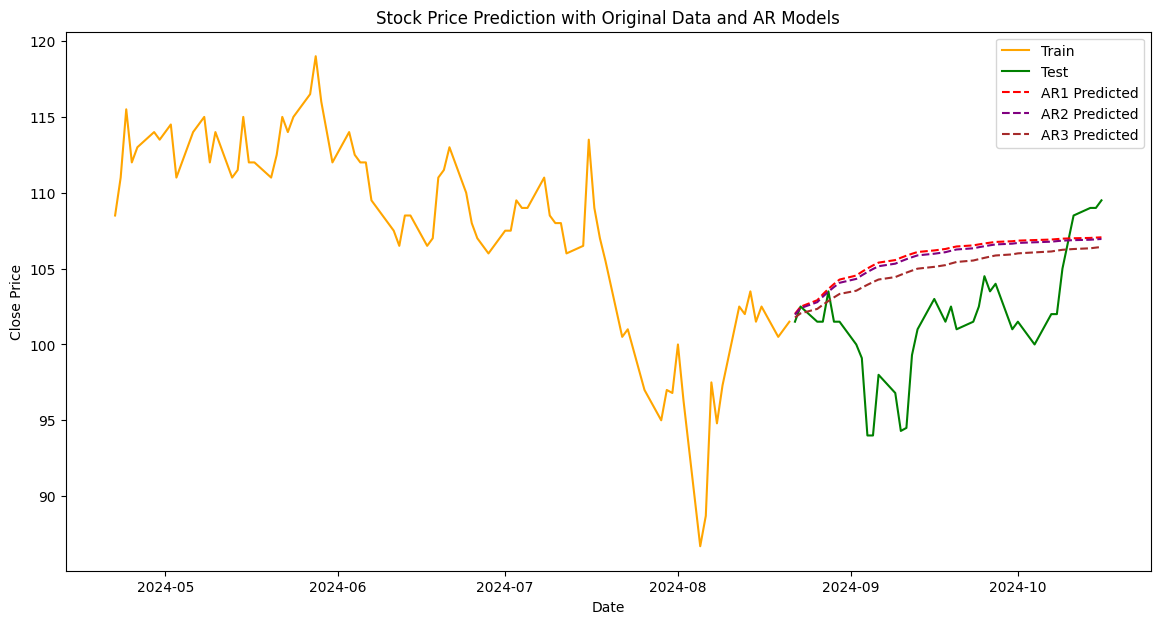

In [18]:
# AR1 模型
ar1_model = ARIMA(train, order=(1, 0, 0)).fit()
ar1_pred = ar1_model.forecast(steps=len(test))
ar1_rmse = np.sqrt(mean_squared_error(test, ar1_pred))
print(f"AR1 RMSE: {ar1_rmse}")

# AR2 模型
ar2_model = ARIMA(train, order=(2, 0, 0)).fit()
ar2_pred = ar2_model.forecast(steps=len(test))
ar2_rmse = np.sqrt(mean_squared_error(test, ar2_pred))
print(f"AR2 RMSE: {ar2_rmse}")

# AR3 模型
ar3_model = ARIMA(train, order=(3, 0, 0)).fit()
ar3_pred = ar3_model.forecast(steps=len(test))
ar3_rmse = np.sqrt(mean_squared_error(test, ar3_pred))
print(f"AR3 RMSE: {ar3_rmse}")

# 繪製訓練集、測試集、最佳模型預測
plt.figure(figsize=(14, 7))

# 繪製訓練集部分
plt.plot(train.index, train, label='Train', color='orange')

# 繪製測試集部分
plt.plot(test.index, test, label='Test', color='green')

# 繪製 AR1 模型的預測結果
plt.plot(test.index, ar1_pred, color='red', linestyle='--', label='AR1 Predicted')

# 繪製 AR2 模型的預測結果
plt.plot(test.index, ar2_pred, color='purple', linestyle='--', label='AR2 Predicted')

# 繪製 AR3 模型的預測結果
plt.plot(test.index, ar3_pred, color='brown', linestyle='--', label='AR3 Predicted')

# 標題和圖例
plt.title('Stock Price Prediction with Original Data and AR Models')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

# 顯示圖形
plt.show()

## 1.3 補充：SARIMA 模型（加入季節性）
加入季節性後，模型可以捕捉到數據中的週期性波動，讓預測更準確地反映固定時間間隔內重複出現的模式。

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX # 引入季節性 ARIMA

SARIMA模型的RMSE: 11.16


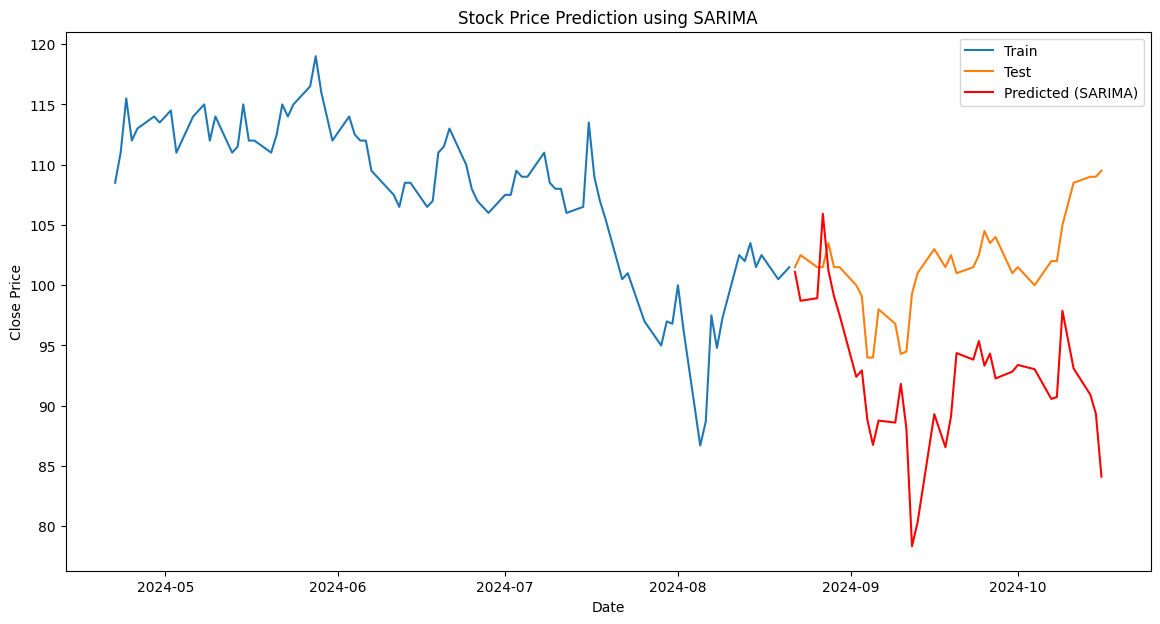

In [20]:
seasonal_period = 28 # 週期為28天

# 建立SARIMA模型
# order=(p, d, q)：非季節性ARIMA部分的參數，p 代表自回歸項，d 代表差分階數，q 代表移動平均項。
# seasonal_order=(P, D, Q, m)：季節性ARIMA部分的參數，P、D、Q 分別是季節性自回歸、差分、移動平均參數，m 代表季節性週期長度。
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, seasonal_period))
model_fit = model.fit(disp=False)

# 預測
yhat = model_fit.forecast(steps=len(test))

# 計算誤差RMSE
rmse = np.sqrt(mean_squared_error(test, yhat))
print(f'SARIMA模型的RMSE: {rmse:.2f}')

# 繪製折線圖
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, yhat, color='red', label='Predicted (SARIMA)')
plt.title('Stock Price Prediction using SARIMA')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# <b>2. 量化交易策略</b>

1. 策略設計：

>
* KD 指標（隨機指標）：當 K 線上穿 D 線時產生買入信號，當 K 線下穿 D 線時產生賣出信號。
* MACD 指標（指數平滑異同移動平均線）：當 MACD 線上穿訊號線（Signal Line）時買入，反之則賣出。
2. 策略的交易邏輯：當 KD 和 MACD 都給出相同方向的信號時進行交易。
* 買入條件：KD 的 K 線上穿 D 線且 MACD 線上穿訊號線。
* 賣出條件：KD 的 K 線下穿 D 線且 MACD 線下穿訊號線。

[*********************100%***********************]  1 of 1 completed


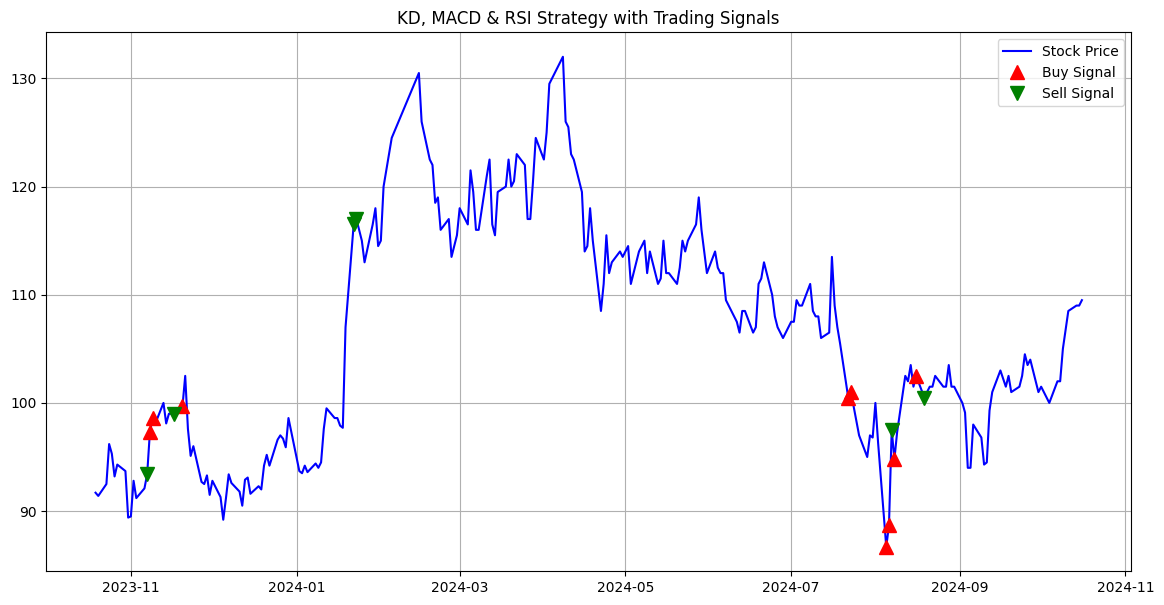

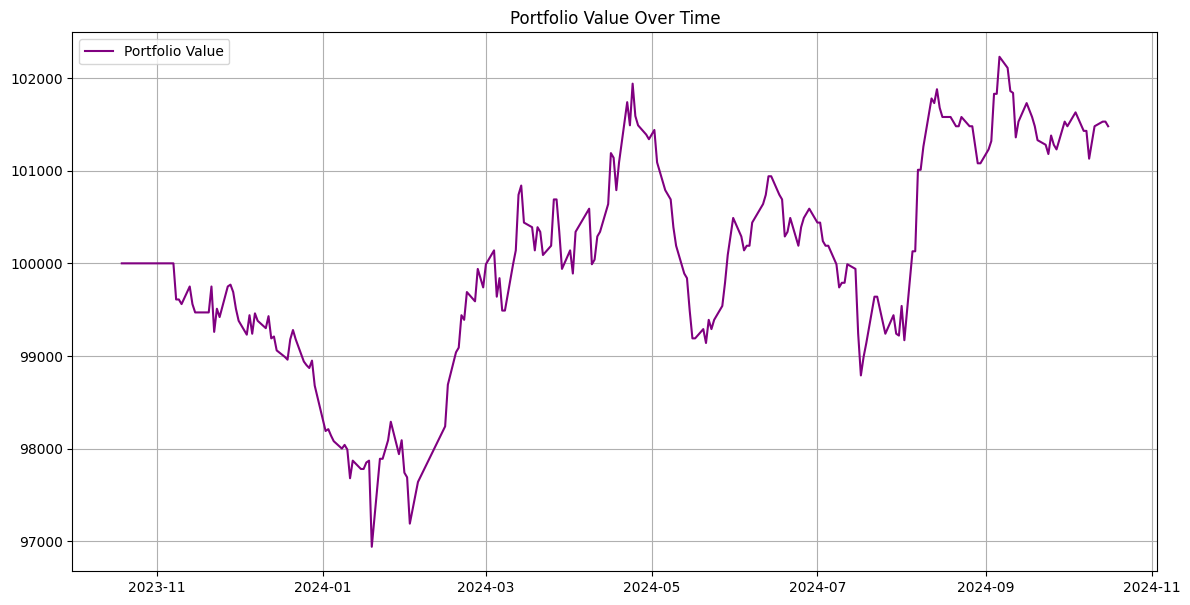

Final Portfolio Value: 101480.00


In [29]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 定義 KD 指標計算
def calculate_kd(data, window=14):
    low_min = data['Low'].rolling(window=window).min()
    high_max = data['High'].rolling(window=window).max()
    data['%K'] = 100 * ((data['Close'] - low_min) / (high_max - low_min))
    data['%D'] = data['%K'].rolling(window=3).mean()
    return data

# 定義 MACD 指標計算
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    data['EMA12'] = data['Close'].ewm(span=short_window, adjust=False).mean()
    data['EMA26'] = data['Close'].ewm(span=long_window, adjust=False).mean()
    data['MACD'] = data['EMA12'] - data['EMA26']
    data['Signal Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()
    return data

# 定義 RSI 計算
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))
    return data

# 改善策略：放寬信號條件，增加交易機會
def trading_strategy_with_rsi(data, stop_loss=0.05, take_profit=0.10, buffer=0.01):
    data['Signal'] = 0

    # 放寬信號條件：當 KD 和 MACD 符合條件即可交易，RSI 作為輔助指標
    # 買入信號：當 KD 的 K 線上穿 D 線 或 MACD 線上穿訊號線，且 RSI < 50（不一定是超賣區）
    data['Signal'][(data['%K'] > data['%D'] + buffer) | (data['MACD'] > data['Signal Line']) & (data['RSI'] < 50)] = 1

    # 賣出信號：當 KD 的 K 線下穿 D 線 或 MACD 線下穿訊號線，且 RSI > 50（不一定是超買區）
    data['Signal'][(data['%K'] < data['%D'] - buffer) | (data['MACD'] < data['Signal Line']) & (data['RSI'] > 50)] = -1

    # 計算信號變化，避免過度交易
    data['Position'] = data['Signal'].diff()

    # 計算每筆交易的持倉收益
    data['Trade Return'] = data['Close'].pct_change() * data['Position'].shift()

    # 引入止損和止盈機制
    data['Signal'][(data['Trade Return'] < -stop_loss)] = -1  # 觸發止損
    data['Signal'][(data['Trade Return'] > take_profit)] = 0   # 觸發止盈
    data['Position'] = data['Signal'].diff()

    return data

# 回測策略並可視化結果
def backtest_and_plot(data, initial_capital=100000):
    # 資產淨值初始化
    positions = pd.DataFrame(index=data.index).fillna(0.0)
    positions['Stock'] = data['Signal'] * 100  # 每次交易100股

    # 計算持倉價值
    portfolio = positions.multiply(data['Close'], axis=0)
    pos_diff = positions.diff()

    # 計算現金部分
    portfolio['Holdings'] = positions.multiply(data['Close'], axis=0).sum(axis=1)
    portfolio['Cash'] = initial_capital - (pos_diff.multiply(data['Close'], axis=0)).sum(axis=1).cumsum()

    # 計算總資產
    portfolio['Total'] = portfolio['Cash'] + portfolio['Holdings']

    # 繪製策略結果
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='Stock Price', color='blue')

    # 標註買賣信號
    plt.plot(data[data['Position'] == 1].index, data['Close'][data['Position'] == 1], '^', markersize=10, color='r', lw=0, label='Buy Signal')
    plt.plot(data[data['Position'] == -1].index, data['Close'][data['Position'] == -1], 'v', markersize=10, color='g', lw=0, label='Sell Signal')

    plt.title('KD, MACD & RSI Strategy with Trading Signals')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # 繪製資產淨值曲線
    plt.figure(figsize=(14, 7))
    plt.plot(portfolio['Total'], label='Portfolio Value', color='purple')
    plt.title('Portfolio Value Over Time')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    return portfolio

# 股票代號與資料時間範圍
stock_id = "3231.tw"
end = pd.Timestamp.today()
start = end - pd.Timedelta(days=365)

# 抓取股票數據
stock_data = yf.download(stock_id, start=start, end=end)

# 計算 KD, MACD 和 RSI
stock_data = calculate_kd(stock_data)
stock_data = calculate_macd(stock_data)
stock_data = calculate_rsi(stock_data)

# 應用交易策略，並加入 RSI 作為輔助指標
stock_data = trading_strategy_with_rsi(stock_data)

# 回測策略並可視化結果
portfolio = backtest_and_plot(stock_data)

# 最後輸出策略的最終資產淨值
final_value = portfolio['Total'].iloc[-1]
print(f"Final Portfolio Value: {final_value:.2f}")

# 參考

## 2.1 均值回歸策略

**如何產生買入和賣出信號？**

* 黃金交叉（Golden Cross）：當短期移動平均線（短期 MA）從下方突破長期移動平均線（長期 MA），這被認為是一個買入信號。這代表著短期內價格上升的趨勢開始超過長期趨勢，市場可能進入一個上漲階段。

* 死亡交叉（Death Cross）：當短期 MA從上方跌破長期 MA，這被認為是一個賣出信號。這代表著短期內的價格趨勢弱於長期趨勢，市場可能進入下跌階段。

In [80]:
# 取得股票資訊，輸入股票代號
stock_id = "3231.tw"

# 資料結束時間
end = pd.Timestamp.today()
start = end - pd.Timedelta(days=365)


# 參數1: 股票代號, 參數2: 開始時間, 參數3: 結束時間
stock_data = yf.download(stock_id, start=start, end=end).reset_index()

# 將日期欄位設為資料表索引
stock_data.set_index('Date', inplace=True)
stock_data.index = pd.to_datetime(stock_data.index)

stock_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-10-19,90.699997,92.500000,89.000000,91.699997,89.533333,92717461
2023-10-20,90.000000,93.300003,88.500000,91.400002,89.240425,86023588
2023-10-23,90.900002,94.500000,90.599998,92.500000,90.314430,62851855
2023-10-24,93.699997,96.300003,92.699997,96.199997,93.927010,100474352
2023-10-25,96.300003,97.000000,95.099998,95.300003,93.048279,62053005
...,...,...,...,...,...,...
2024-10-09,103.500000,105.500000,103.000000,105.000000,105.000000,39992237
2024-10-11,105.500000,109.000000,104.500000,108.500000,108.500000,55431430
2024-10-14,109.500000,110.000000,107.500000,109.000000,109.000000,31188138


In [79]:
# 設計均值回歸策略
def mean_reversion_strategy(data, short_window, long_window):
    data['Short_MA'] = data['Close'].rolling(window=short_window).mean()
    data['Long_MA'] = data['Close'].rolling(window=long_window).mean()

    # 初始訊號：0 代表不操作
    data['Signal'] = 0

    # 短均線高於長均線，發出買入信號
    # .astype('int64') 將 True 變成1，False 變成0
    data.iloc[short_window:, data.columns.get_loc('Signal')] = (
        data['Short_MA'].iloc[short_window:] > data['Long_MA'].iloc[short_window:]
    ).astype('int64')
    # .diff() 使用差分計算買入或賣出(True 代表 1， False代表 0)
    # 當信號從 False（0）變為 True（1）時，1 - 0 = 1 差分為 1，表示買入信號。
    # 當信號從 True（1）變為 False（0）時，0 - 1 = -1 差分為 -1，表示賣出信號。
    data['Position'] = data['Signal'].diff()
    return data

In [81]:
# 回測策略並可視化結果
def backtest_and_plot(data):
    # 資產淨值初始化
    initial_capital = 100000

    # 填空值為 0.0
    positions = pd.DataFrame(index=data.index).fillna(0.0)

    # 買入訊號(1)或賣出訊號(-1) * 股數，-100代表賣100股，100代表買100股
    positions['Stock'] = data['Signal'] * 100  # 每次交易100股

    # 買入或賣出股票數 * 收盤價，計算每個時間點持有的股票價值
    portfolio = positions.multiply(data['Close'], axis=0)

    # 計算每個時間點股票持倉的變化量（買入或賣出股票的數量）
    pos_diff = positions.diff()

    # 計算持有的股票價值（資產組合中持有的部分）
    portfolio['Holdings'] = positions.multiply(data['Close'], axis=0).sum(axis=1)

    # 計算現金部分
    portfolio['Cash'] = initial_capital - (pos_diff.multiply(data['Close'], axis=0)).sum(axis=1).cumsum()

    # 計算總資產
    portfolio['Total'] = portfolio['Cash'] + portfolio['Holdings']

    # 繪製策略結果
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='Stock Price', color='blue')
    plt.plot(data['Short_MA'], label='Short Moving Average', color='green')
    plt.plot(data['Long_MA'], label='Long Moving Average', color='red')

    # 標註買賣點
    plt.plot(data[data['Position'] == 1].index,
             data['Short_MA'][data['Position'] == 1],
             '^', markersize=10, color='r', lw=0, label='Buy Signal')

    plt.plot(data[data['Position'] == -1].index,
             data['Short_MA'][data['Position'] == -1],
             'v', markersize=10, color='g', lw=0, label='Sell Signal')

    plt.title('Mean Reversion Strategy Backtest')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # 繪製資產淨值曲線
    plt.figure(figsize=(14, 7))
    plt.plot(portfolio['Total'], label='Portfolio Value', color='purple')
    plt.title('Portfolio Value Over Time')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # 返回計算出的 portfolio 結果
    return portfolio

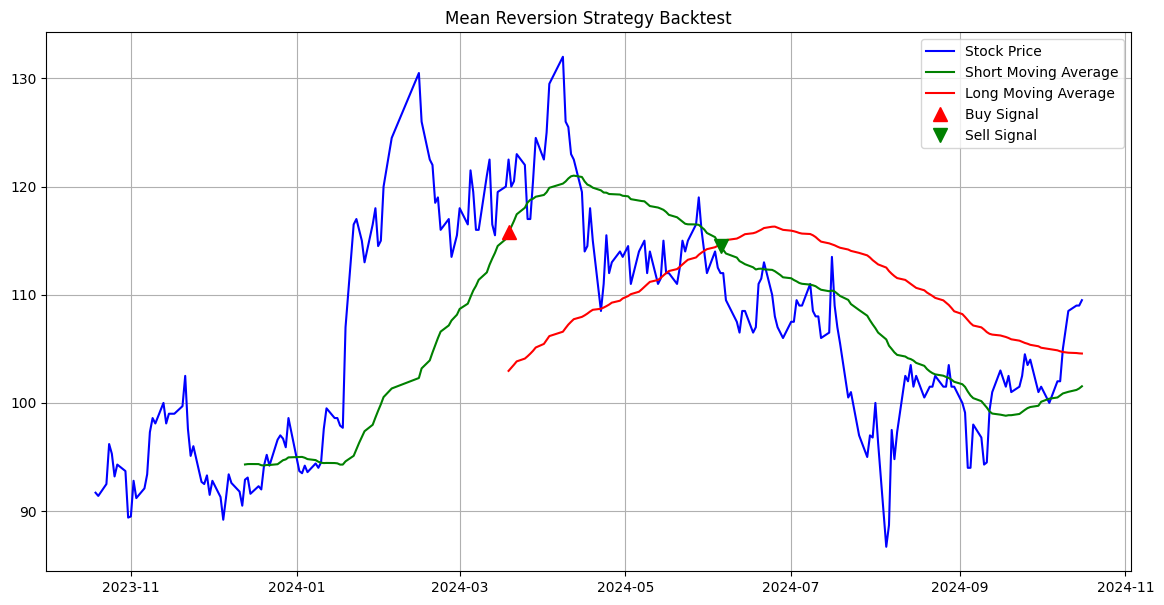

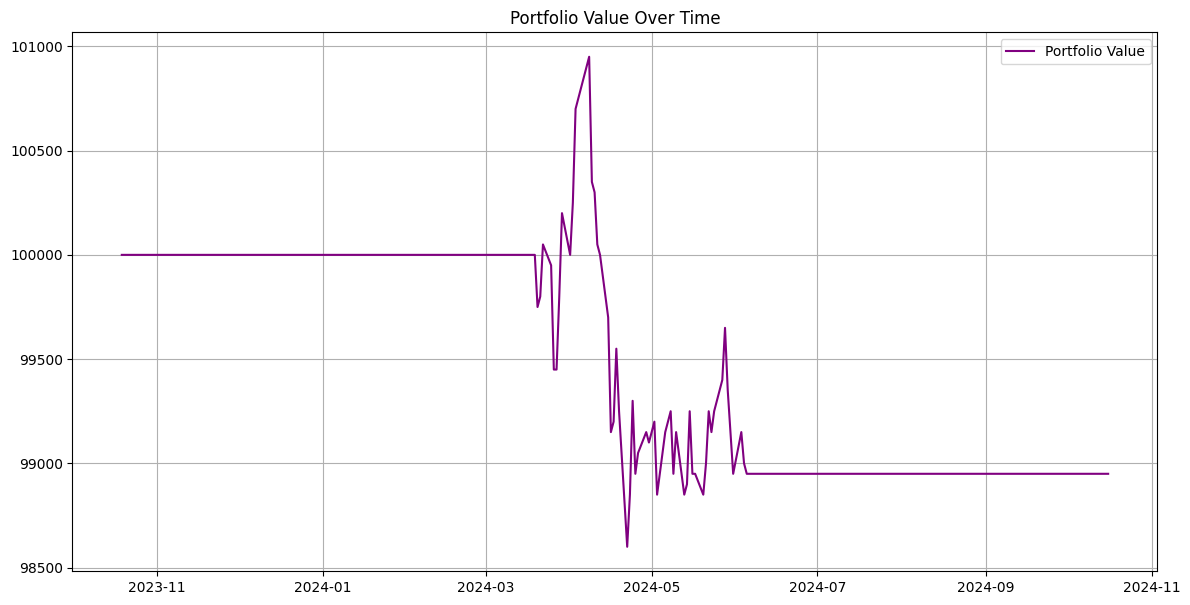

Final Portfolio Value: 98950.00


In [82]:
# 設定策略參數：短期移動平均線窗口與長期移動平均線窗口
short_window = 40
long_window = 100

# 應用均值回歸策略
stock_data = mean_reversion_strategy(stock_data, short_window, long_window)

# 回測並可視化結果
portfolio = backtest_and_plot(stock_data)

# 最後輸出策略的最終資產淨值
final_value = portfolio['Total'].iloc[-1]
print(f"Final Portfolio Value: {final_value:.2f}")

## 2.2 動量策略
**動量策略的基本概念**

1. 趨勢延續：動量策略假設「趨勢具有延續性」。這意味著當某種資產的價格在過去一段時間內持續上升或下降，這個趨勢很有可能在短期內繼續維持。因此，動量策略會根據資產的歷史表現來預測未來的價格變動方向。

2. 上升買入，下降賣出：動量策略的操作原則是「追漲殺跌」：
    * 買入信號：當價格顯示出持續上升的動能時，投資者會進場買入，以期未來價格能夠進一步上漲。
    * 賣出信號：當價格顯示出下降的動能時，投資者會賣出持有的資產，預防價格繼續下跌。

In [72]:
# 輸入股票代號
stock_id = "3231.tw"


end = pd.Timestamp.today()
start = end - pd.Timedelta(days=365)

# 參數1: 股票代號, 參數2: 開始時間, 參數3: 結束時間
stock_data = yf.download(stock_id, start=start, end=end).reset_index()

# 將日期欄位設為資料表索引
stock_data.set_index('Date', inplace=True)
stock_data.index = pd.to_datetime(stock_data.index)

stock_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-10-19,90.699997,92.500000,89.000000,91.699997,89.533333,92717461
2023-10-20,90.000000,93.300003,88.500000,91.400002,89.240425,86023588
2023-10-23,90.900002,94.500000,90.599998,92.500000,90.314430,62851855
2023-10-24,93.699997,96.300003,92.699997,96.199997,93.927010,100474352
2023-10-25,96.300003,97.000000,95.099998,95.300003,93.048279,62053005
...,...,...,...,...,...,...
2024-10-09,103.500000,105.500000,103.000000,105.000000,105.000000,39992237
2024-10-11,105.500000,109.000000,104.500000,108.500000,108.500000,55431430
2024-10-14,109.500000,110.000000,107.500000,109.000000,109.000000,31188138


In [73]:
# 動量策略設計 (基於價格變動百分比)
def momentum_strategy(data, window, threshold):
    # 計算動量：基於過去 window 天的百分比變化
    # pct_change 計算股票收盤價在指定的時間窗口（window）內的百分比變化
    data['Momentum'] = data['Close'].pct_change(window) * 100  # 轉換為百分比
    data['Signal'] = 0  # 初始訊號

    # 設定當動量變化超過閾值時觸發交易信號
    data.iloc[window:, data.columns.get_loc('Signal')] = [
        1 if momentum > threshold else -1 if momentum < -threshold else 0 for momentum in data['Momentum'].iloc[window:]
    ]

    # 當信號從 0 變為 1 時，1 - 0 = 1 差分為 1，表示買入信號。
    # 當信號從 1 變為 0 時，0 - 1 = -1 差分為 -1，表示賣出信號。
    data['Position'] = data['Signal'].diff()  # 訊號變化產生操作
    return data

In [74]:
# 回測策略並可視化結果
def backtest_and_plot(data):
    # 資產淨值初始化
    initial_capital = 100000

    # 填空值為 0.0
    positions = pd.DataFrame(index=data.index).fillna(0.0)

    # 買入訊號(1)或賣出訊號(-1) * 股數，-100代表賣100股，100代表買100股
    positions['Stock'] = data['Signal'] * 100  # 每次交易100股

   # 買入或賣出股票數 * 收盤價，計算每個時間點持有的股票價值
    portfolio = positions.multiply(data['Close'], axis=0)

    # 計算每個時間點股票持倉的變化量（買入或賣出股票的數量）
    pos_diff = positions.diff()


    # 計算持有的股票價值（資產組合中持有的部分）
    # 將持倉數量與收盤價相乘，並對每個時間點的所有持倉進行求和，得到當天的總持倉價值
    portfolio['Holdings'] = positions.multiply(data['Close'], axis=0).sum(axis=1)

    # 計算現金部分
    # 初始資金減去所有交易的累積花費/收益，並根據股票價格乘以持倉變動來計算現金變化
    # cumsum() 用來累積計算現金變化，保持隨著時間推移的總現金變化
    portfolio['Cash'] = initial_capital - (pos_diff.multiply(data['Close'], axis=0)).sum(axis=1).cumsum()

    # 計算總資產
    # 總資產 = 現金部分 + 持有的股票價值部分
    portfolio['Total'] = portfolio['Cash'] + portfolio['Holdings']

    # 繪製策略結果
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='Stock Price', color='blue')

    # 標註買賣信號
    plt.plot(data[data['Position'] == 1].index,
             data['Close'][data['Position'] == 1],
             '^', markersize=10, color='r', lw=0, label='Buy Signal')

    plt.plot(data[data['Position'] == -1].index,
             data['Close'][data['Position'] == -1],
             'v', markersize=10, color='g', lw=0, label='Sell Signal')

    plt.title('Momentum Strategy with Percentage Change and Threshold')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # 繪製資產淨值曲線
    plt.figure(figsize=(14, 7))
    plt.plot(portfolio['Total'], label='Portfolio Value', color='purple')
    plt.title('Portfolio Value Over Time')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

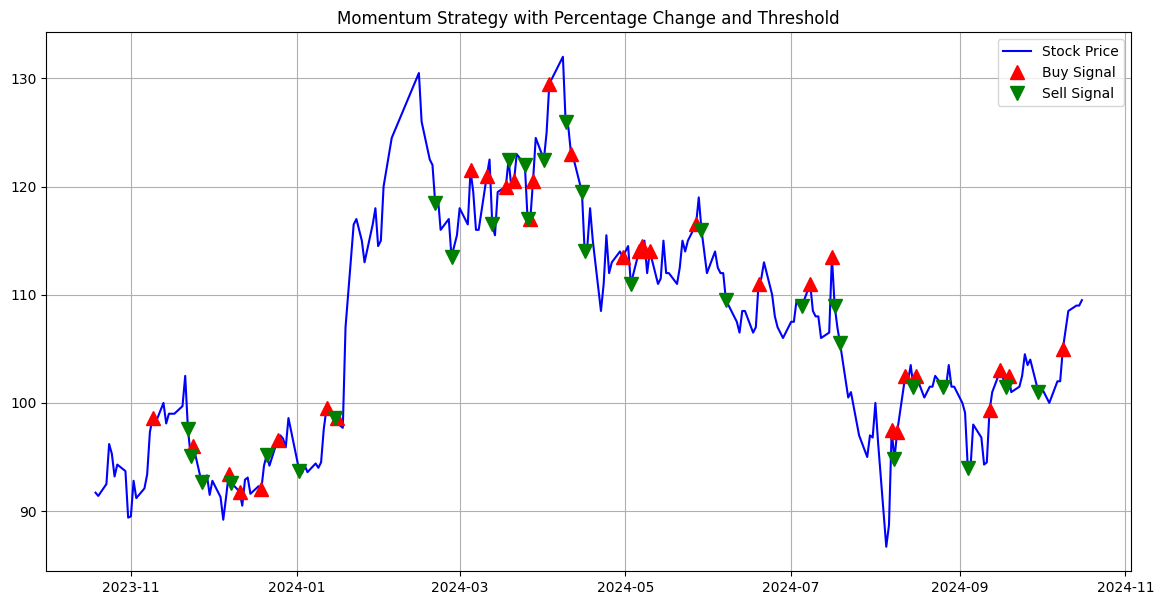

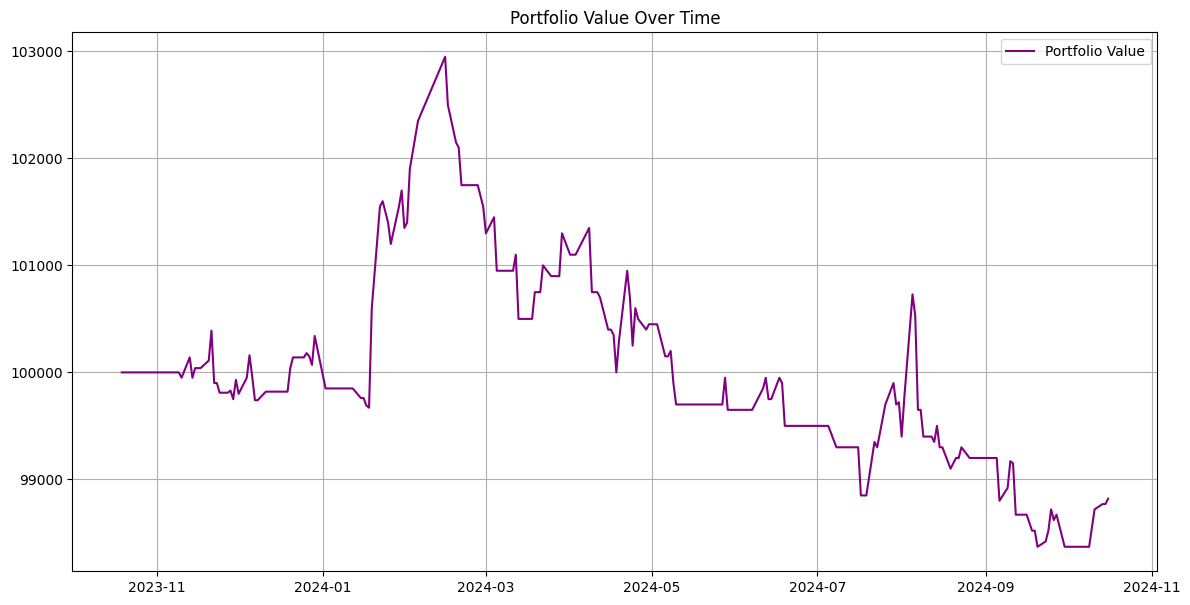

Final Portfolio Value: 98950.00


In [75]:
# 設定策略參數：動量計算的窗口期與百分比閾值
momentum_window = 10  # 設定動量窗口為10天
threshold = 3  # 當價格變動百分比超過3%時觸發買賣信號

# 應用動量策略
stock_data = momentum_strategy(stock_data, momentum_window, threshold)

# 回測並可視化結果
final_value = backtest_and_plot(stock_data)
# 最後輸出策略的最終資產淨值
final_value = portfolio['Total'].iloc[-1]
print(f"Final Portfolio Value: {final_value:.2f}")